# Targeted optimization method

## IMPORTS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch

In [3]:
from utils import MnistData, Clipper
from models import ModelManager, ModelType
from adversarials import ClassificationAdversarials

In [4]:
import numpy as np
from matplotlib import pyplot as plt

## SETTINGS

In [5]:
linfty_norm_radius = 50 / 255
lone_norm_radius = 28 * 28 * 50 / 255
ltwo_norm_radius = 28 * 50 / 255

In [6]:
model = ModelManager.get_trained(ModelType.MnistCnnB)

In [28]:
batch_size = 10

In [8]:
data = MnistData(True)

## FUNCTIONS

In [9]:
def mnist_batch_linfty_norm(input:torch.Tensor) -> torch.Tensor:
    return torch.max(torch.max(torch.max(torch.abs(input), dim=3)[0], dim=2)[0], dim=1)[0]

def mnist_batch_lone_norm(input:torch.Tensor) -> torch.Tensor:
    return (torch.abs(input)).sum(3).sum(2).sum(1)

def mnist_batch_ltwo_norm(input:torch.Tensor) -> torch.Tensor:
    return ((input ** 2).sum(3).sum(2).sum(1)) ** (1 / 2)

In [23]:
def get_adv(model, benign_examples, target_labels, batch_norm_function, norm_radius, c, clip_always=False):
    step_size = 1e-2
    adversarial_examples = torch.zeros(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    for _ in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        loss = c * batch_norm_function(adversarial_examples - benign_examples).sum() \
            + loss_fn(model(adversarial_examples), target_labels)
        loss.backward()
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
        if clip_always:
            adversarial_examples = Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm_function, norm_radius)
    return Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm_function, norm_radius)


def lbfgs_batch(model, benign_examples, labels, norm_radius, batch_norm_function, clip_always=False):
    batch = len(benign_examples)
    all_adversarial_examples = torch.zeros(batch, 9, 28, 28)
    target_labels = torch.tensor([[i for i in range(10) if i != label] for label in labels])
    for i in range(9):
        print(f'--- {i} ---')
        successful_indexes = []
        unsuccessful_indexes = [i for i in range(batch)]
        c = 100
        while unsuccessful_indexes:
            still_benign_examples = torch.tensor([benign_examples[j].tolist() for j in unsuccessful_indexes])
            still_target_labels = torch.tensor([target_labels[j, i] for j in unsuccessful_indexes])
            adversarial_examples = get_adv(model, still_benign_examples, still_target_labels, batch_norm_function, norm_radius, c, clip_always)
            adversarial_preds = torch.argmax(model(adversarial_examples), dim=1)
            indexes_to_delete = []
            for j in range(len(adversarial_examples)):
                # print(j)
                if adversarial_preds[j] != labels[unsuccessful_indexes[j]] or c <= 0.01:
                    all_adversarial_examples[unsuccessful_indexes[j], i, :, :] = adversarial_examples[j, :, :, :]
                    successful_indexes.append(unsuccessful_indexes[j])
                    indexes_to_delete.append(unsuccessful_indexes[j])
            for j in indexes_to_delete:
                unsuccessful_indexes.remove(j)
            c *= 0.1
    expanded_examples = benign_examples.expand(batch, 9, 28, 28)
    diffs = all_adversarial_examples - expanded_examples
    norms = torch.zeros(batch, 9)
    for i in range(9):
        norms[:, i] = batch_norm_function(diffs[:, i, :, :].reshape(batch, 1, 28, 28))
    selected_adversarial_examples = torch.zeros(benign_examples.shape)
    indexes = torch.argmin(norms, dim=1)
    for i in range(batch):
        selected_adversarial_examples[i, 0, :, :] = all_adversarial_examples[i, indexes[i], :, :]
    return selected_adversarial_examples

## GENERATION

In [29]:
benign_examples, labels = data.choose_first_well_classified(batch_size, model)

In [30]:
lbfgs_linfty_examples_clip_always = lbfgs_batch(model, benign_examples, labels, linfty_norm_radius, mnist_batch_linfty_norm, True)
lbfgs_lone_examples_clip_always = lbfgs_batch(model, benign_examples, labels, lone_norm_radius, mnist_batch_lone_norm, True)
lbfgs_ltwo_examples_clip_always = lbfgs_batch(model, benign_examples, labels, ltwo_norm_radius, mnist_batch_ltwo_norm, True)

lbfgs_linfty_examples_clip_once = lbfgs_batch(model, benign_examples, labels, linfty_norm_radius, mnist_batch_linfty_norm)
lbfgs_lone_examples_clip_once = lbfgs_batch(model, benign_examples, labels, lone_norm_radius, mnist_batch_lone_norm)
lbfgs_ltwo_examples_clip_once = lbfgs_batch(model, benign_examples, labels, ltwo_norm_radius, mnist_batch_ltwo_norm)

--- 0 ---
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 0 ---
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 0 ---
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 0 ---
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 0 ---
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 0 ---
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---


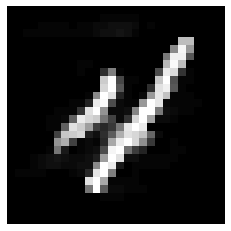

In [33]:
# Save'em all
for i in range(batch_size):
    example = np.array(benign_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\L-BFGS_BATCH\\benign_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(lbfgs_linfty_examples_clip_always[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\L-BFGS_BATCH\\clip_always_lbfgs_linfty_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(lbfgs_lone_examples_clip_always[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\L-BFGS_BATCH\\clip_always_lbfgs_lone_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(lbfgs_ltwo_examples_clip_always[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\L-BFGS_BATCH\\clip_always_lbfgs_ltwo_{i}.png", bbox_inches="tight", pad_inches=0)

    example = np.array(lbfgs_linfty_examples_clip_once[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\L-BFGS_BATCH\\clip_once_lbfgs_linfty_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(lbfgs_lone_examples_clip_once[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\L-BFGS_BATCH\\clip_once_lbfgs_lone_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(lbfgs_ltwo_examples_clip_once[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\L-BFGS_BATCH\\clip_once_lbfgs_ltwo_{i}.png", bbox_inches="tight", pad_inches=0)


In [32]:

linfty_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_linfty_examples_clip_always)
print(f'lbfgs_linfty_always: {len(linfty_adversarials)}')

lone_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_lone_examples_clip_always)
print(f'lbfgs_lone_always: {len(lone_adversarials)}')

ltwo_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_ltwo_examples_clip_always)
print(f'lbfgs_ltwo_always: {len(ltwo_adversarials)}')

linfty_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_linfty_examples_clip_once)
print(f'lbfgs_linfty_once: {len(linfty_adversarials)}')

lone_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_lone_examples_clip_once)
print(f'lbfgs_lone_once: {len(lone_adversarials)}')

ltwo_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_ltwo_examples_clip_once)
print(f'lbfgs_ltwo_once: {len(ltwo_adversarials)}')

lbfgs_linfty_always: 8
lbfgs_lone_always: 8
lbfgs_ltwo_always: 2
lbfgs_linfty_once: 0
lbfgs_lone_once: 8
lbfgs_ltwo_once: 10
